# Cogs 118c final project

## Anand Mysorekar, Leo Fleury

In [1]:
print('hello')

hello


# Loading Data

In [ ]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt

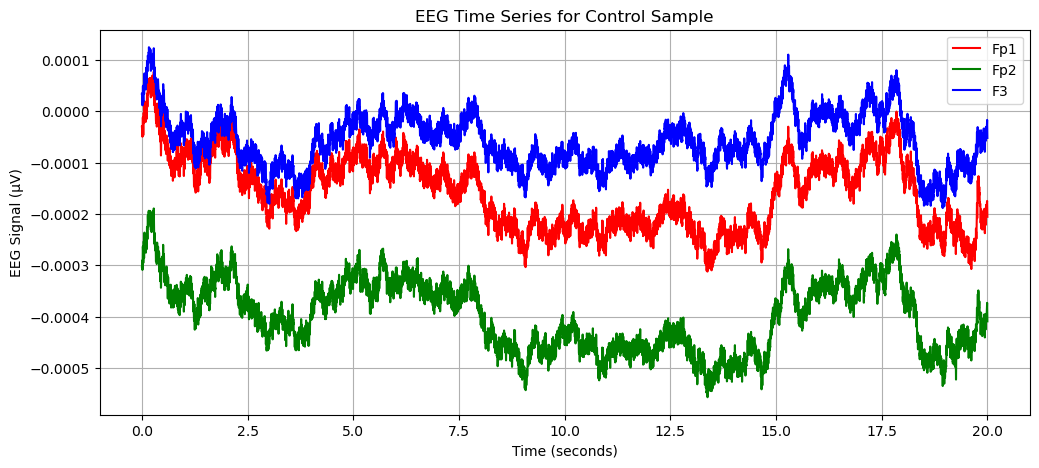

In [5]:
control_path = r'C:\Users\anand\OneDrive\Desktop\school_vscode\cogs 118b\cogs118c-project\Control_EEG_sub_027.npy'
ad_path = r'C:\Users\anand\OneDrive\Desktop\school_vscode\cogs 118b\cogs118c-project\AD_EEG_sub_001.npy'

Control = np.load(control_path)
AD = np.load(ad_path)

fs = 500  # Sampling rate (Hz)
num_samples = Control.shape[1]  # 10000 samples

time = np.linspace(0, num_samples / fs, num_samples)

channels = ['Fp1', 'Fp2', 'F3']
colors = ['r', 'g', 'b']  # Red, Green, Blue

plt.figure(figsize=(12, 5))
for i in range(3):
    plt.plot(time, Control[i, :], label=channels[i], color=colors[i])

# Formatting
plt.xlabel("Time (seconds)")
plt.ylabel("EEG Signal (µV)")
plt.title("EEG Time Series for Control Sample")
plt.legend()
plt.grid(True)

# Show plot
plt.show()